# Results

Within this notebook, we load the results, and create the tables and plots for the paper. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_metrics(df_results, mode, metric_name, file=None):
    if mode == 'basic':
        type_names = ['Int-0:1000', 'Float-0:1000', 'English']
        
        _, axes = plt.subplots(2, 2, figsize=(6, 5))
        for i, type in enumerate(type_names):
            row = i%2
            col = i//2
            ax = axes[row, col]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', style='Model', errorbar=None, ax=ax)
            ax.set_title(type)
        plt.suptitle(metric_name)
        plt.tight_layout()
        axes[1,1].legend(*axes[1,0].get_legend_handles_labels(), loc='upper center')
        axes[1,1].axis('off')
        axes[0,0].legend().remove()
        axes[0,1].legend().remove()
        axes[1,0].legend().remove()
    elif mode == 'advanced':
        type_names = ['Int-10000000:10001000',
                      'Int-n1000:1000',
                      'Float-10000000:10001000',
                      'Float-0:0.0001',
                      'Float-n1000-1000',
                      'ascii',
                      'aScIi',
                      'PrfxEnglish',
                      'NumberWords']
        
        _, axes = plt.subplots(5, 2, figsize=(6, 10))
        for i, type in enumerate(type_names):
            row = i%5
            col = i//5
            ax = axes[row, col]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', style='Model', errorbar=None, ax=ax)
            ax.set_title(type)
        plt.suptitle(metric_name)
        plt.tight_layout()
        axes[4,1].legend(*axes[4,0].get_legend_handles_labels(), loc='upper left')
        axes[4,1].axis('off')
        axes[0,0].legend().remove()
        axes[0,1].legend().remove()
        axes[1,0].legend().remove()
        axes[1,1].legend().remove()
        axes[2,0].legend().remove()
        axes[2,1].legend().remove()
        axes[3,0].legend().remove()
        axes[3,1].legend().remove()
        axes[4,0].legend().remove()
    elif mode == 'debug':
        type_names = ['Int-Sorted', 'Float-Sorted', 'English-Sorted', 'Int-Duplicate', 'Float-Duplicate', 'English-Duplicate']
        
        _, axes = plt.subplots(3, 2, figsize=(6, 7))
        for i, type in enumerate(type_names):
            row = i%3
            col = i//3
            ax = axes[row, col]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', style='Model', errorbar=None, ax=ax)
            ax.set_title(type)
        plt.suptitle(metric_name)
        plt.tight_layout()
        axes[2,0].legend(ncol=2, loc='lower left', bbox_to_anchor=(0.3, -0.9))
        axes[0,0].legend().remove()
        axes[0,1].legend().remove()
        axes[1,0].legend().remove()
        axes[1,1].legend().remove()
        axes[2,1].legend().remove()

    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

def plot_aggregated_results(df_results, mode, file=None):
    metrics = ['SortBench Score', 'Validity Score', 'Sorting Score', 'Faithfulness Score']
    _, axes = plt.subplots(2, 2, figsize=(9,6))
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        if mode=='all':
            df_results_mode = df_results
        else:
            df_results_mode = df_results[df_results['Mode'] == mode]
        sns.lineplot(x='Size', y=metric, data=df_results_mode, hue='Model', style='Model', ax=ax, errorbar=None)
        ax.set_title(f"{metric} ({mode})")
    
    plt.tight_layout()
    axes[0,0].legend().remove()
    axes[0,1].legend().remove()
    axes[1,1].legend().remove()
    axes[1,0].legend(ncol=2, loc='lower left', bbox_to_anchor=(0.6, -0.6))
    
    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    plt.show()

def aggregate_scores(df_results, mode):
    if mode=='all':
        df_results_mode = df_results
    else:
        df_results_mode = df_results[df_results['Mode'] == mode]
    df_results_mode = df_results_mode[['Model', 'Size', 'SortBench Score', 'Sorting Score', 'Faithfulness Score', 'Validity Score']]

    results_per_size = df_results_mode.groupby(['Model', 'Size'], observed=True).mean(numeric_only=True).reset_index()
    sum_of_sizes = results_per_size['Size'].unique().sum()
    results_per_size['Weighted SortBench Score'] = results_per_size['Size']*results_per_size['SortBench Score']
    results_per_size['Weighted Sorting Score'] = results_per_size['Size']*results_per_size['Sorting Score']
    results_per_size['Weighted Faithfulness Score'] = results_per_size['Size']*results_per_size['Faithfulness Score']
    results_per_size['Weighted Validity Score'] = results_per_size['Size']*results_per_size['Validity Score']
    results_per_model = results_per_size.groupby('Model', observed=True).sum(numeric_only=True)[['Weighted SortBench Score', 'Weighted Sorting Score', 'Weighted Faithfulness Score', 'Weighted Validity Score']]/sum_of_sizes
    results_per_model = pd.DataFrame(results_per_model).sort_values('Weighted SortBench Score', ascending=False).reset_index()
    return results_per_model

def create_latex_table(results_per_model, mode):
    latex_code = results_per_model.to_latex(index=False, float_format="%.3f")
    latex_code = latex_code.replace('Weighted ', '')
    rpl_string = r'\midrule\n\parbox[t]{2mm}{\multirow{7}{*}{\rotatebox[origin=c]{90}{'+mode.title()+r'}}}'
    latex_code = latex_code.replace(r'\midrule', rpl_string)
    return latex_code

def adjust_names_for_output(df_results):
    model_name_map = {'gpt-4o': 'GPT-4o',
                      'gpt-4o-mini': 'GPT-4o-mini',
                      'claude-3-5-haiku-20241022': 'Claude-3.5-Haiku',
                      'claude-3-5-sonnet-20241022': 'Claude-3.5-Sonnet',
                      'llama3.1': 'Llama-3.1',
                      'deepseekr1': 'DeepSeek-r1'}
    df_results['Model'] = df_results['Model'].replace(model_name_map)
    df_results['Model'] = pd.Categorical(df_results['Model'], ['Claude-3.5-Haiku', 'Claude-3.5-Sonnet', 'GPT-4o', 'GPT-4o-mini', 'Llama-3.1', 'DeepSeek-r1', 'o3-mini'])

    type_name_map = {'ASCII-Lower': 'ascii',
                     'ASCII-Cased': 'aScIi',
                     'Integers-10000000:10001000': 'Int-10000000:10001000'}
    df_results['Type'] = df_results['Type'].replace(type_name_map)
    return df_results

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule\n\parbox[t]{2mm}{\multirow{7}{*}{\rotatebox[origin=c]{90}{Basic}}}
o3-mini & 0.984 & 0.997 & 0.970 & 1.000 \\
GPT-4o & 0.931 & 0.986 & 0.955 & 0.954 \\
GPT-4o-mini & 0.901 & 0.978 & 0.888 & 0.964 \\
Claude-3.5-Sonnet & 0.862 & 0.998 & 0.912 & 0.895 \\
Claude-3.5-Haiku & 0.830 & 0.992 & 0.904 & 0.869 \\
Llama-3.1 & 0.727 & 0.989 & 0.709 & 0.832 \\
DeepSeek-r1 & 0.562 & 0.823 & 0.694 & 0.679 \\
\bottomrule
\end{tabular}



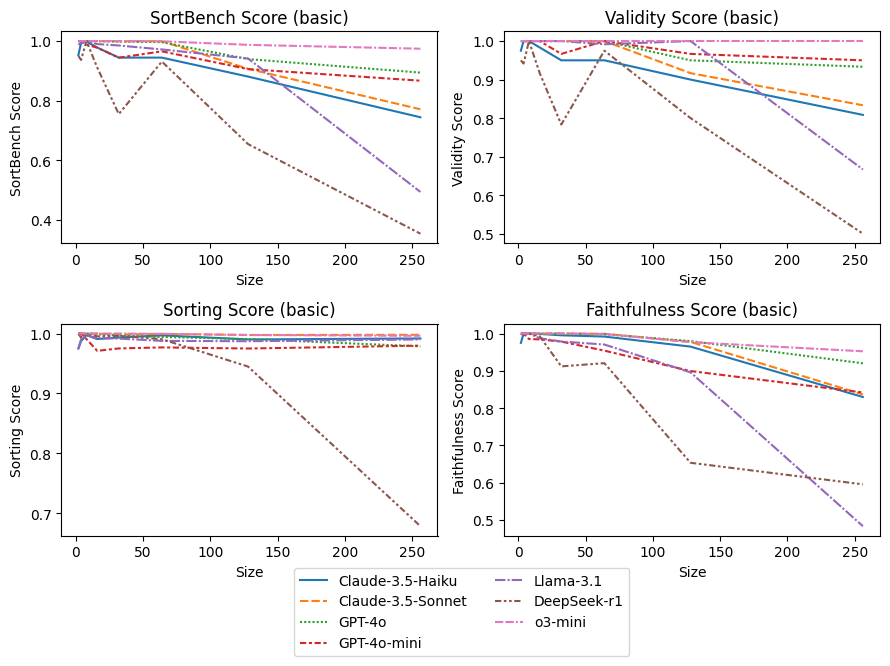

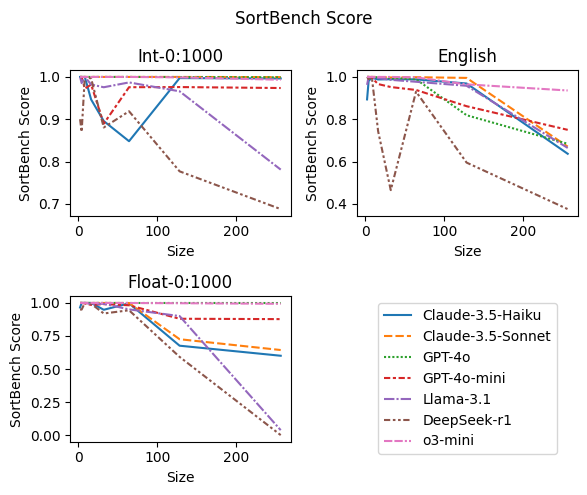

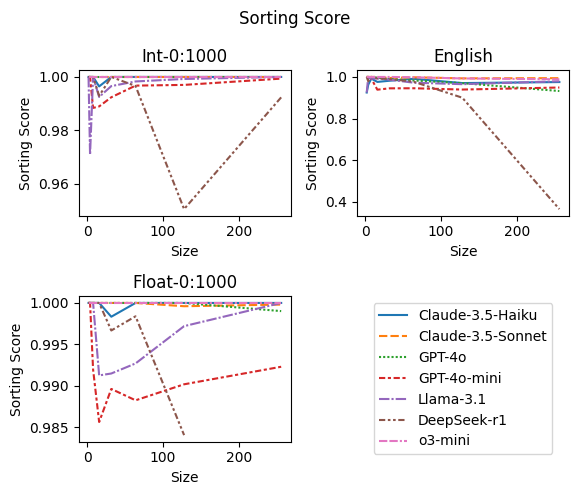

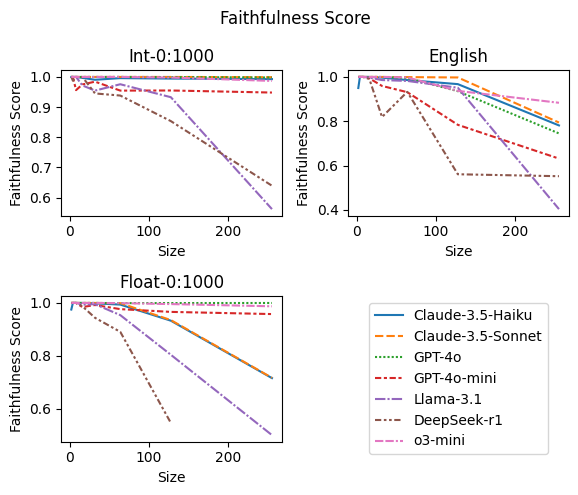

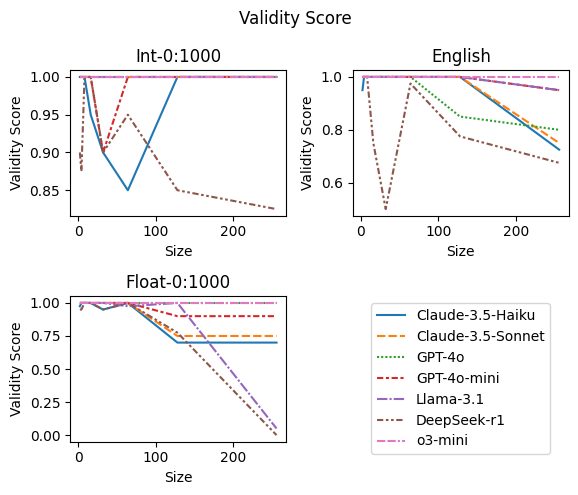

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule\n\parbox[t]{2mm}{\multirow{7}{*}{\rotatebox[origin=c]{90}{Advanced}}}
o3-mini & 0.965 & 0.986 & 0.946 & 0.999 \\
GPT-4o & 0.839 & 0.855 & 0.889 & 0.953 \\
Claude-3.5-Sonnet & 0.786 & 0.954 & 0.870 & 0.854 \\
Claude-3.5-Haiku & 0.764 & 0.930 & 0.850 & 0.852 \\
GPT-4o-mini & 0.690 & 0.711 & 0.744 & 0.945 \\
Llama-3.1 & 0.643 & 0.837 & 0.658 & 0.836 \\
DeepSeek-r1 & 0.474 & 0.951 & 0.614 & 0.593 \\
\bottomrule
\end{tabular}



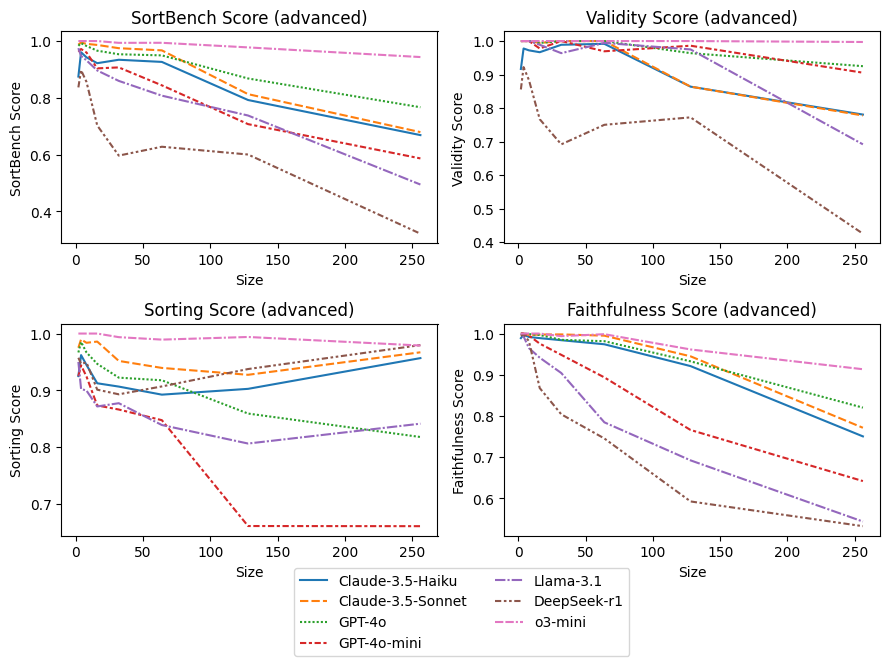

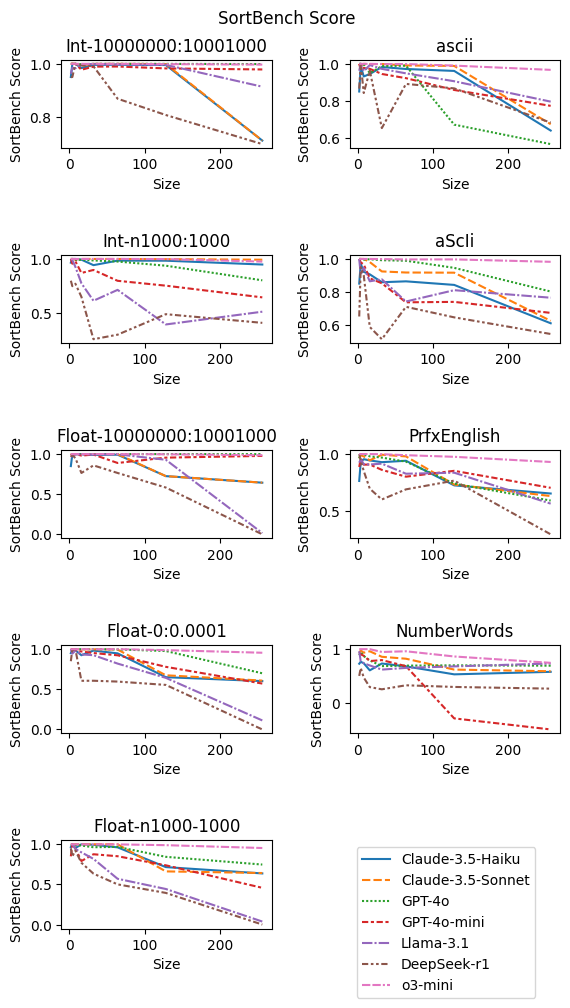

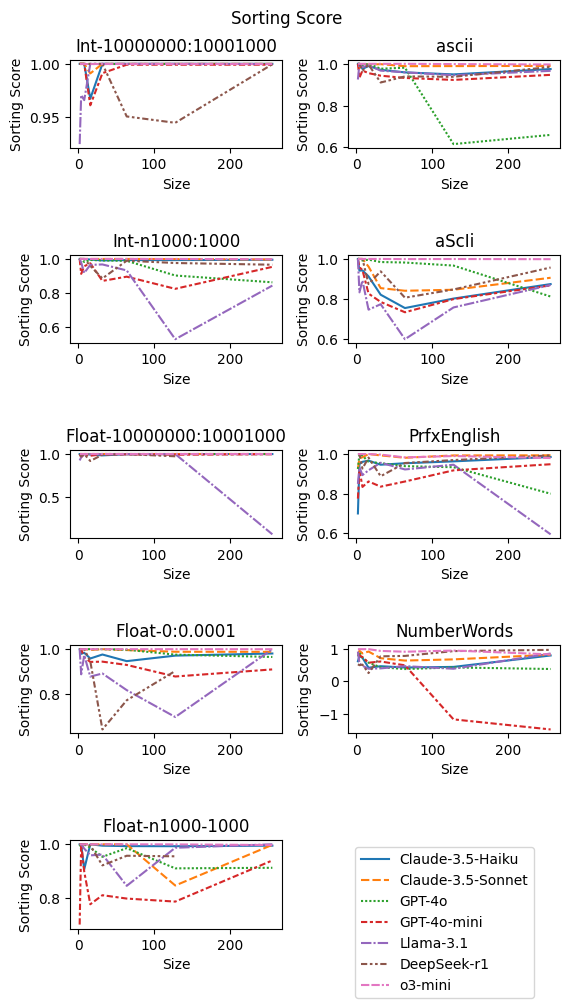

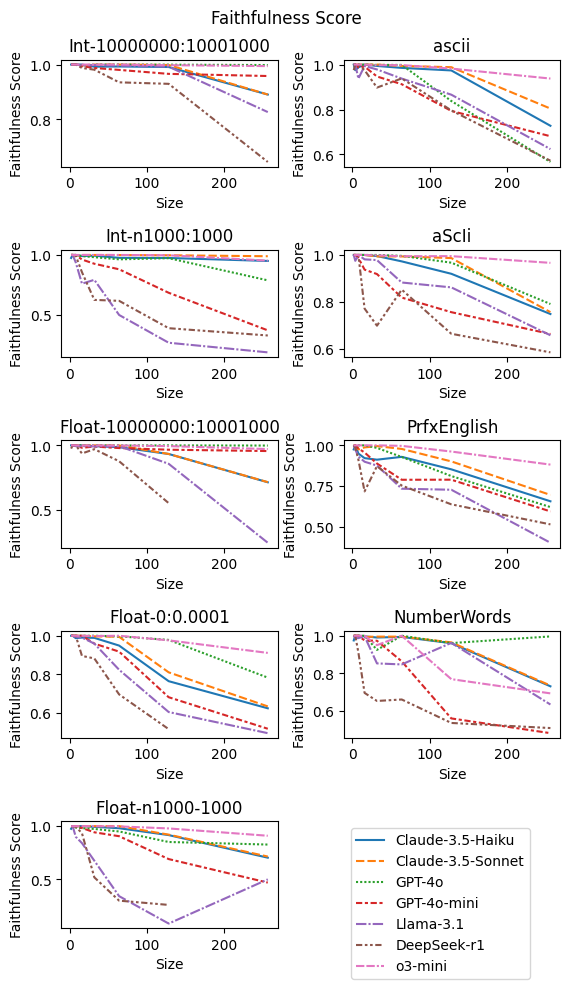

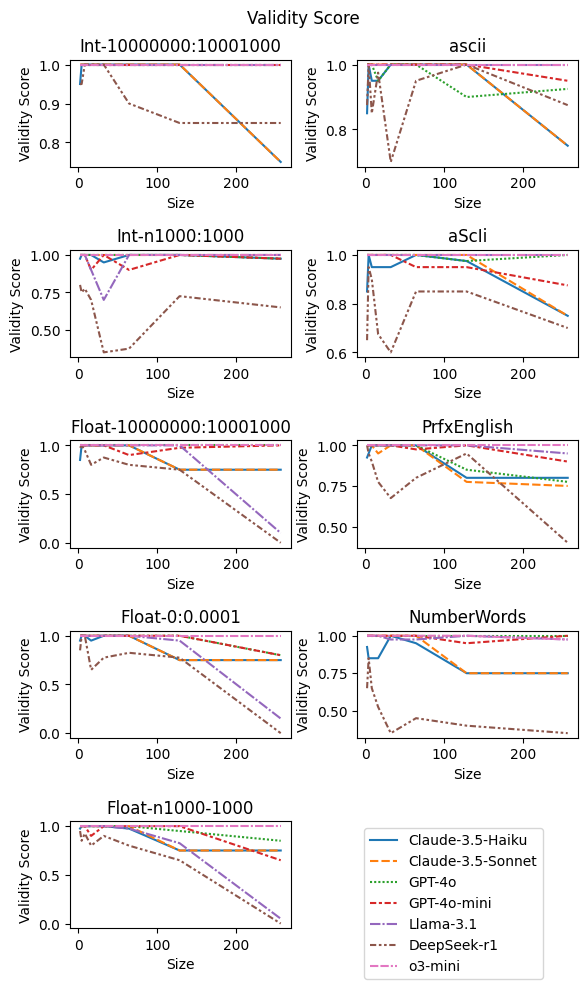

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule\n\parbox[t]{2mm}{\multirow{7}{*}{\rotatebox[origin=c]{90}{Debug}}}
GPT-4o & 0.998 & 0.998 & 0.998 & 1.000 \\
o3-mini & 0.995 & 0.999 & 0.991 & 1.000 \\
GPT-4o-mini & 0.938 & 0.990 & 0.905 & 0.990 \\
Claude-3.5-Sonnet & 0.863 & 1.000 & 0.913 & 0.895 \\
Claude-3.5-Haiku & 0.844 & 0.998 & 0.898 & 0.886 \\
Llama-3.1 & 0.780 & 0.980 & 0.803 & 0.858 \\
DeepSeek-r1 & 0.615 & 0.991 & 0.756 & 0.684 \\
\bottomrule
\end{tabular}



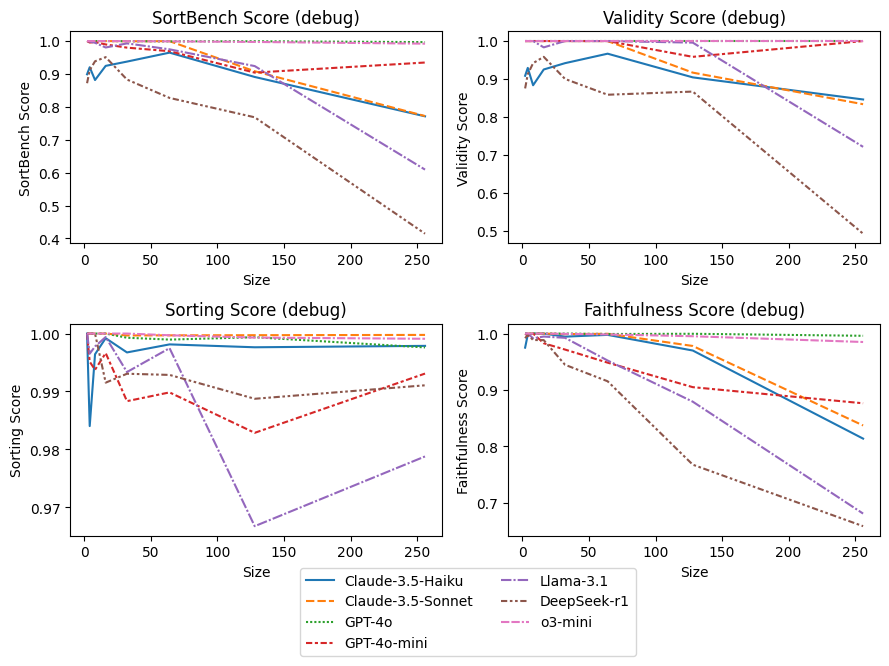

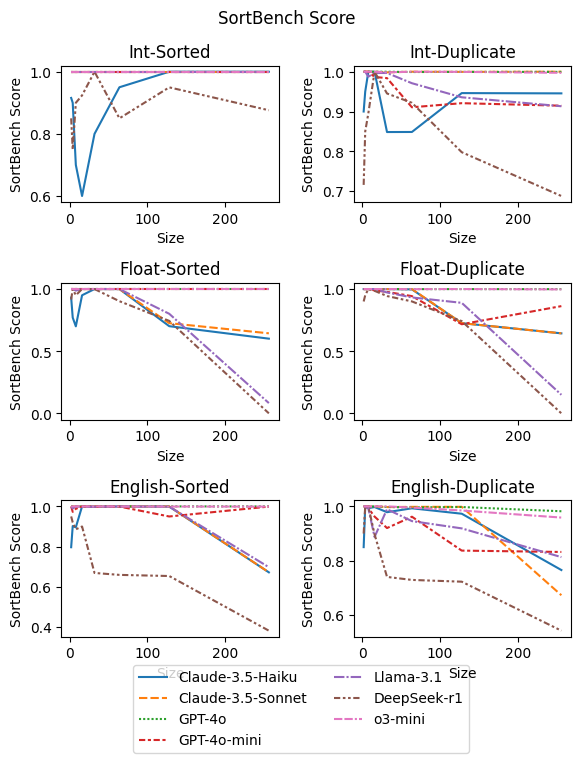

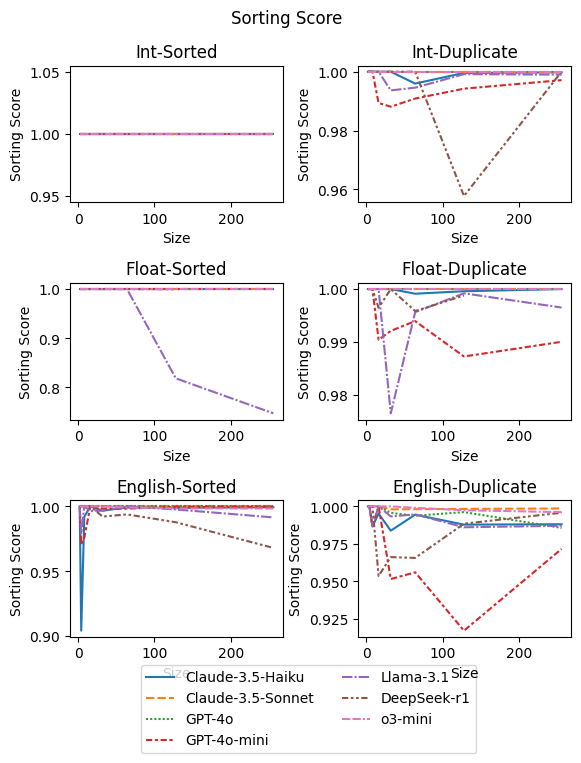

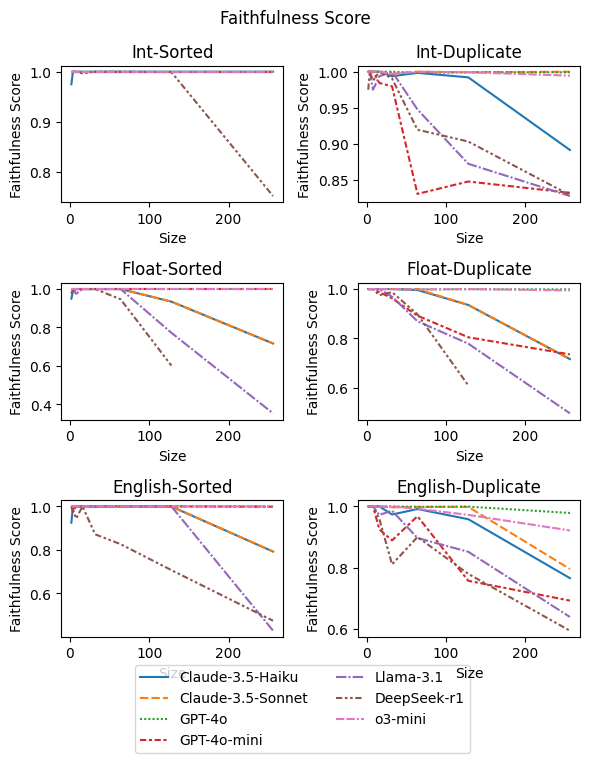

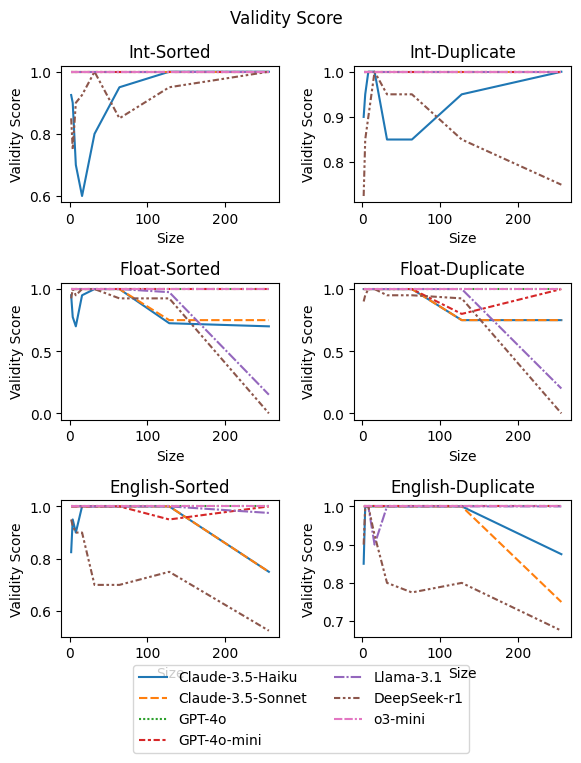

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule\n\parbox[t]{2mm}{\multirow{7}{*}{\rotatebox[origin=c]{90}{All}}}
o3-mini & 0.978 & 0.992 & 0.965 & 0.999 \\
GPT-4o & 0.908 & 0.925 & 0.937 & 0.969 \\
Claude-3.5-Sonnet & 0.824 & 0.976 & 0.891 & 0.875 \\
GPT-4o-mini & 0.808 & 0.850 & 0.823 & 0.963 \\
Claude-3.5-Haiku & 0.802 & 0.963 & 0.875 & 0.866 \\
Llama-3.1 & 0.703 & 0.911 & 0.716 & 0.843 \\
DeepSeek-r1 & 0.536 & 0.941 & 0.677 & 0.638 \\
\bottomrule
\end{tabular}



In [2]:
benchmark_modes = ['basic', 'advanced', 'debug']
version = "v1.0"

results = {}
for mode in benchmark_modes:
    df_results = pd.read_csv(f'../scores/scores_{mode}_{version}.csv')
    df_results = adjust_names_for_output(df_results)
    results[mode] = df_results
    results_per_model = aggregate_scores(df_results, mode)
    print(create_latex_table(results_per_model, mode))
    plot_aggregated_results(df_results, mode, file=f'../figures/{mode}_aggregated_results.pdf')
    plot_metrics(df_results, mode, 'SortBench Score', file=f'../figures/{mode}_sortbench_score.pdf')
    plot_metrics(df_results, mode, 'Sorting Score', file=f'../figures/{mode}_sorting_score.pdf')
    plot_metrics(df_results, mode, 'Faithfulness Score', file=f'../figures/{mode}_faithfulness_score.pdf')
    plot_metrics(df_results, mode, 'Validity Score', file=f'../figures/{mode}_validity_score.pdf')

# results for all tasks together
df_results_all = pd.concat(results.values(), ignore_index=True)
results_per_model_all = aggregate_scores(df_results_all, 'all')
print(create_latex_table(results_per_model_all, 'all'))

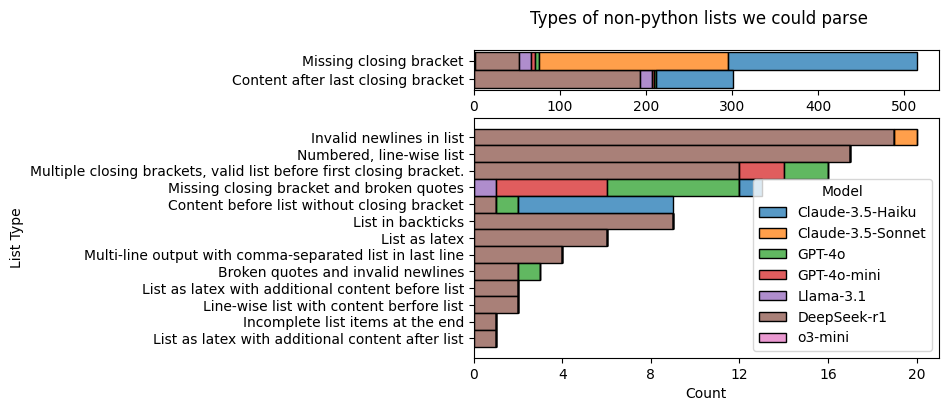

In [3]:
error_order = df_results_all.groupby(['ErrorType']).count()['Model'].sort_values(ascending=False).index.tolist()
df_results_all['ErrorType'] = pd.Categorical(df_results_all['ErrorType'], error_order)

fig, axes = plt.subplots(2,1, figsize=(6, 4), gridspec_kw={'height_ratios': [1, 6]})
ax = axes[0]
sns.histplot(df_results_all[(df_results_all['ErrorType']=='Missing closing bracket' ) | (df_results_all['ErrorType']=='Content after last closing bracket')], y='ErrorType', hue='Model', multiple='stack', legend=False, ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax = axes[1]
df_results_all_filtered = df_results_all.loc[(df_results_all['ErrorType']!='Missing closing bracket' ) & (df_results_all['ErrorType']!='Content after last closing bracket'), :].copy()
df_results_all_filtered['ErrorType'] = pd.Categorical(df_results_all_filtered['ErrorType'], [e for e in error_order if e not in ['Missing closing bracket','Content after last closing bracket']])
sns.histplot(df_results_all_filtered, y='ErrorType', hue='Model', multiple='stack', ax=ax)
ax.set_xticks(range(0, 21, 4))
plt.ylabel('List Type')
plt.suptitle('Types of non-python lists we could parse')
plt.savefig('../figures/error_types.pdf', bbox_inches='tight')
plt.show()

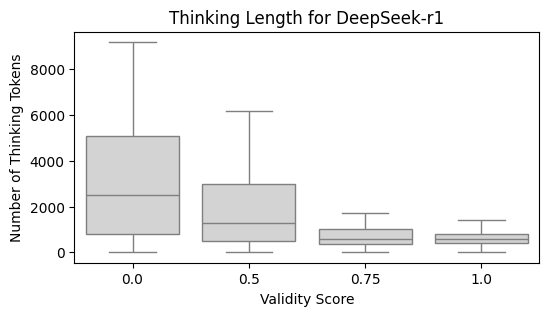

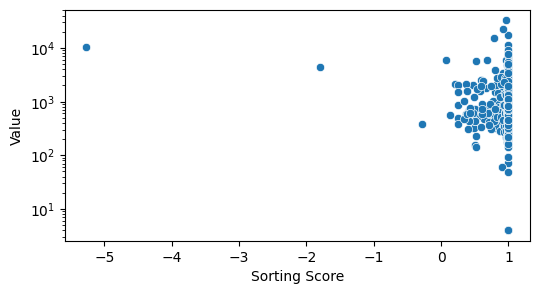

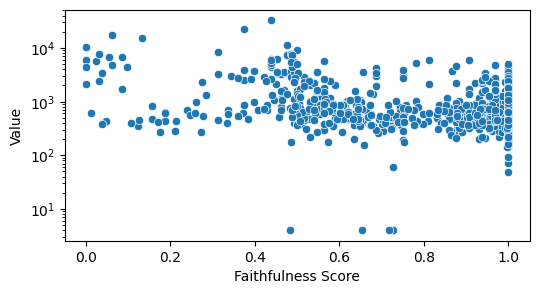

In [4]:
melted_results_thinking = pd.melt(df_results_all, id_vars=['Model', 'Validity Score', 'Sorting Score', 'Faithfulness Score'], value_vars=['Thinking Length'], var_name='Metric', value_name='Value')

plt.figure(figsize=(6, 3))
sns.boxplot(data=melted_results_thinking[melted_results_thinking['Model']=='DeepSeek-r1'], x='Validity Score', y='Value', showfliers=False, color='lightgray')
plt.title('Thinking Length for DeepSeek-r1')
plt.ylabel('Number of Thinking Tokens')
plt.savefig('../figures/thinking_length_deepseekr1.pdf', bbox_inches='tight')
plt.show()
plt.figure(figsize=(6, 3))
sns.scatterplot(data=melted_results_thinking[melted_results_thinking['Model']=='DeepSeek-r1'], x='Sorting Score', y='Value')
plt.yscale('log')
plt.show()
plt.figure(figsize=(6, 3))
sns.scatterplot(data=melted_results_thinking[melted_results_thinking['Model']=='DeepSeek-r1'], x='Faithfulness Score', y='Value')
plt.yscale('log')
plt.show()

In [12]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

from autorank import autorank, latex_table

# convert to wide form
for size in df_results_all['Size'].unique():
    results_wide = df_results_all.loc[df_results_all['Size']==size, ['Model', 'Type', 'Size', 'List Name', 'SortBench Score']].pivot(index=['Type', 'Size', 'List Name'], columns='Model', values='SortBench Score')
    results_wide.reset_index(inplace=True, drop=True)
    res = autorank(results_wide, approach='bayesian', order='descending')
    
    print('% list size:', size)
    latex_table(res)
    print()
    display(res.posterior_matrix)

% list size: 2
\begin{table}[h]
\centering
\begin{tabular}{lrrlrrl}
\toprule
 & M & SD & CI & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  \\
\midrule
o3-mini & 1.000 & 0.000 & [1.000, 1.000] & - & - & - \\
Claude-3.5-Sonnet & 0.994 & 0.048 & [0.982, 1.006] & 1.000 & 0.000 & equal \\
GPT-4o & 0.992 & 0.055 & [0.978, 1.005] & 1.000 & 0.000 & equal \\
Llama-3.1 & 0.985 & 0.073 & [0.967, 1.004] & 1.000 & 0.000 & equal \\
GPT-4o-mini & 0.981 & 0.082 & [0.961, 1.002] & 1.000 & 0.000 & equal \\
Claude-3.5-Haiku & 0.896 & 0.187 & [0.850, 0.943] & 0.934 & 0.066 & inconclusive \\
DeepSeek-r1 & 0.867 & 0.232 & [0.809, 0.925] & 0.842 & 0.158 & inconclusive \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,Claude-3.5-Sonnet,GPT-4o,Llama-3.1,GPT-4o-mini,Claude-3.5-Haiku,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.06644, 0.93356, 0.0)","(0.15846, 0.84154, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.02226, 0.97774, 0.0)","(0.17258, 0.82742, 0.0)"
GPT-4o,NaN,NaN,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.01838, 0.98162, 0.0)","(0.10374, 0.89626, 0.0)"
Llama-3.1,NaN,NaN,NaN,NaN,"(0.0, 1.0, 0.0)","(0.03308, 0.96692, 0.0)","(0.28254, 0.71746, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,NaN,NaN,"(0.02968, 0.97032, 0.0)","(0.25824, 0.74176, 0.0)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,NaN,NaN,"(0.1671, 0.82708, 0.00582)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


% list size: 4
\begin{table}[h]
\centering
\begin{tabular}{lrrlrrl}
\toprule
 & M & SD & CI & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  \\
\midrule
o3-mini & 1.000 & 0.000 & [1.000, 1.000] & - & - & - \\
Claude-3.5-Sonnet & 0.997 & 0.017 & [0.993, 1.002] & 1.000 & 0.000 & equal \\
GPT-4o & 0.996 & 0.026 & [0.990, 1.003] & 1.000 & 0.000 & equal \\
GPT-4o-mini & 0.984 & 0.055 & [0.971, 0.998] & 1.000 & 0.000 & equal \\
Llama-3.1 & 0.972 & 0.072 & [0.955, 0.990] & 1.000 & 0.000 & equal \\
Claude-3.5-Haiku & 0.953 & 0.135 & [0.919, 0.986] & 1.000 & 0.000 & equal \\
DeepSeek-r1 & 0.909 & 0.193 & [0.861, 0.957] & 0.992 & 0.008 & equal \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,Claude-3.5-Sonnet,GPT-4o,GPT-4o-mini,Llama-3.1,Claude-3.5-Haiku,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(2e-05, 0.99998, 0.0)","(0.0, 1.0, 0.0)","(0.0084, 0.9916, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.00764, 0.99236, 0.0)"
GPT-4o,NaN,NaN,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.00438, 0.99562, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.0049, 0.9951, 0.0)"
Llama-3.1,NaN,NaN,NaN,NaN,NaN,"(0.0, 1.0, 0.0)","(0.0031, 0.9969, 0.0)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,NaN,NaN,"(0.00382, 0.99618, 0.0)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


% list size: 8
\begin{table}[h]
\centering
\begin{tabular}{lrrlrrl}
\toprule
 & M & SD & CI & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  \\
\midrule
o3-mini & 1.000 & 0.000 & [1.000, 1.000] & - & - & - \\
Claude-3.5-Sonnet & 0.995 & 0.026 & [0.989, 1.002] & 1.000 & 0.000 & equal \\
GPT-4o & 0.991 & 0.039 & [0.982, 1.001] & 1.000 & 0.000 & equal \\
GPT-4o-mini & 0.977 & 0.047 & [0.965, 0.989] & 0.793 & 0.207 & inconclusive \\
Llama-3.1 & 0.964 & 0.082 & [0.944, 0.984] & 0.908 & 0.092 & inconclusive \\
Claude-3.5-Haiku & 0.932 & 0.162 & [0.891, 0.972] & 0.966 & 0.034 & equal \\
DeepSeek-r1 & 0.908 & 0.213 & [0.855, 0.961] & 1.000 & 0.000 & equal \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,Claude-3.5-Sonnet,GPT-4o,GPT-4o-mini,Llama-3.1,Claude-3.5-Haiku,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(0.20684, 0.79316, 0.0)","(0.09162, 0.90838, 0.0)","(0.03364, 0.96636, 0.0)","(0.00042, 0.99958, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,"(0.0, 1.0, 0.0)","(0.10202, 0.89798, 0.0)","(0.07522, 0.92478, 0.0)","(0.0067, 0.9933, 0.0)","(0.00086, 0.99914, 0.0)"
GPT-4o,NaN,NaN,NaN,"(0.08338, 0.91662, 0.0)","(0.09434, 0.90566, 0.0)","(0.04442, 0.95558, 0.0)","(0.00054, 0.99946, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,NaN,"(0.0682, 0.93044, 0.00136)","(0.03342, 0.963, 0.00358)","(0.1566, 0.83384, 0.00956)"
Llama-3.1,NaN,NaN,NaN,NaN,NaN,"(0.0067, 0.99106, 0.00224)","(0.00912, 0.99066, 0.00022)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,NaN,NaN,"(0.00272, 0.99656, 0.00072)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


% list size: 16
\begin{table}[h]
\centering
\begin{tabular}{lrrlllrrl}
\toprule
 & M & SD & CI & $d$ & Magnitude & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  &  &  \\
\midrule
o3-mini & 1.000 & 0.000 & [1.000, 1.000] & - & large & - & - & - \\
Claude-3.5-Sonnet & 0.993 & 0.041 & [0.983, 1.003] & 0.235 & small & 1.000 & 0.000 & equal \\
GPT-4o & 0.983 & 0.068 & [0.966, 1.000] & 0.354 & small & 1.000 & 0.000 & equal \\
GPT-4o-mini & 0.945 & 0.127 & [0.913, 0.976] & 0.616 & medium & 0.000 & 1.000 & smaller \\
Llama-3.1 & 0.940 & 0.138 & [0.906, 0.974] & 0.614 & medium & 0.182 & 0.818 & inconclusive \\
Claude-3.5-Haiku & 0.932 & 0.158 & [0.893, 0.972] & 0.605 & medium & 0.958 & 0.042 & equal \\
DeepSeek-r1 & 0.820 & 0.302 & [0.745, 0.896] & 0.840 & large & 0.221 & 0.779 & inconclusive \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,Claude-3.5-Sonnet,GPT-4o,GPT-4o-mini,Llama-3.1,Claude-3.5-Haiku,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0)","(0.81824, 0.18176, 0.0)","(0.0421, 0.9579, 0.0)","(0.7792, 0.2208, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,"(0.0, 1.0, 0.0)","(0.99998, 2e-05, 0.0)","(0.64582, 0.35418, 0.0)","(0.02332, 0.97668, 0.0)","(0.7987, 0.2013, 0.0)"
GPT-4o,NaN,NaN,NaN,"(0.99618, 0.00382, 0.0)","(0.25662, 0.74338, 0.0)","(0.002, 0.998, 0.0)","(0.7361, 0.2639, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,NaN,"(0.02822, 0.7942, 0.17758)","(0.0145, 0.0671, 0.9184)","(0.98884, 0.01116, 0.0)"
Llama-3.1,NaN,NaN,NaN,NaN,NaN,"(0.0008, 0.97122, 0.02798)","(0.65936, 0.34064, 0.0)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,NaN,NaN,"(0.66094, 0.33906, 0.0)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


% list size: 32
\begin{table}[h]
\centering
\begin{tabular}{lrrlllrrl}
\toprule
 & M & SD & CI & $d$ & Magnitude & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  &  &  \\
\midrule
o3-mini & 0.997 & 0.027 & [0.990, 1.003] & 0.000 & negligible & - & - & - \\
Claude-3.5-Sonnet & 0.987 & 0.044 & [0.976, 0.998] & 0.265 & small & 1.000 & 0.000 & equal \\
GPT-4o & 0.976 & 0.085 & [0.955, 0.997] & 0.324 & small & 1.000 & 0.000 & equal \\
GPT-4o-mini & 0.938 & 0.108 & [0.911, 0.965] & 0.749 & medium & 0.000 & 1.000 & smaller \\
Claude-3.5-Haiku & 0.937 & 0.138 & [0.903, 0.971] & 0.600 & medium & 0.431 & 0.569 & inconclusive \\
Llama-3.1 & 0.925 & 0.165 & [0.884, 0.966] & 0.607 & medium & 0.001 & 1.000 & smaller \\
DeepSeek-r1 & 0.719 & 0.358 & [0.630, 0.808] & 1.097 & large & 0.000 & 1.000 & smaller \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,Claude-3.5-Sonnet,GPT-4o,GPT-4o-mini,Claude-3.5-Haiku,Llama-3.1,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.0, 1.0, 0.0)","(8e-05, 0.99992, 0.0)","(1.0, 0.0, 0.0)","(0.56874, 0.43126, 0.0)","(0.9995, 0.0005, 0.0)","(1.0, 0.0, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,"(2e-05, 0.99998, 0.0)","(1.0, 0.0, 0.0)","(0.16188, 0.83812, 0.0)","(0.98718, 0.01282, 0.0)","(1.0, 0.0, 0.0)"
GPT-4o,NaN,NaN,NaN,"(1.0, 0.0, 0.0)","(0.00294, 0.99706, 0.0)","(0.6994, 0.3006, 0.0)","(1.0, 0.0, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,NaN,"(0.00078, 0.03752, 0.9617)","(0.0102, 0.88654, 0.10326)","(1.0, 0.0, 0.0)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,NaN,"(0.11702, 0.88296, 2e-05)","(1.0, 0.0, 0.0)"
Llama-3.1,NaN,NaN,NaN,NaN,NaN,NaN,"(0.9998, 0.0002, 0.0)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


% list size: 64
\begin{table}[h]
\centering
\begin{tabular}{lrrlllrrl}
\toprule
 & M & SD & CI & $d$ & Magnitude & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  &  &  \\
\midrule
o3-mini & 0.996 & 0.025 & [0.990, 1.003] & 0.000 & negligible & - & - & - \\
Claude-3.5-Sonnet & 0.983 & 0.050 & [0.971, 0.996] & 0.333 & small & 1.000 & 0.000 & equal \\
GPT-4o & 0.974 & 0.073 & [0.956, 0.992] & 0.414 & small & 0.992 & 0.008 & equal \\
Claude-3.5-Haiku & 0.942 & 0.124 & [0.911, 0.973] & 0.607 & medium & 0.014 & 0.986 & smaller \\
GPT-4o-mini & 0.906 & 0.151 & [0.868, 0.944] & 0.838 & large & 0.000 & 1.000 & smaller \\
Llama-3.1 & 0.891 & 0.191 & [0.843, 0.938] & 0.776 & medium & 0.000 & 1.000 & smaller \\
DeepSeek-r1 & 0.745 & 0.314 & [0.667, 0.823] & 1.130 & large & 0.000 & 1.000 & smaller \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,Claude-3.5-Sonnet,GPT-4o,Claude-3.5-Haiku,GPT-4o-mini,Llama-3.1,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.0, 1.0, 0.0)","(0.0083, 0.9917, 0.0)","(0.98564, 0.01436, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,"(4e-05, 0.99996, 0.0)","(0.84468, 0.15532, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
GPT-4o,NaN,NaN,NaN,"(0.00266, 0.99734, 0.0)","(1.0, 0.0, 0.0)","(0.99986, 0.00014, 0.0)","(1.0, 0.0, 0.0)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0)","(0.95724, 0.04276, 0.0)","(1.0, 0.0, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,NaN,NaN,"(0.34456, 0.27328, 0.38216)","(1.0, 0.0, 0.0)"
Llama-3.1,NaN,NaN,NaN,NaN,NaN,NaN,"(0.99994, 6e-05, 0.0)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


% list size: 128
\begin{table}[h]
\centering
\begin{tabular}{lrrlllrrl}
\toprule
 & M & SD & CI & $d$ & Magnitude & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  &  &  \\
\midrule
o3-mini & 0.986 & 0.047 & [0.974, 0.998] & 0.000 & negligible & - & - & - \\
GPT-4o & 0.924 & 0.209 & [0.872, 0.976] & 0.408 & small & 1.000 & 0.000 & equal \\
Claude-3.5-Sonnet & 0.860 & 0.153 & [0.822, 0.899] & 1.106 & large & 0.000 & 1.000 & smaller \\
Claude-3.5-Haiku & 0.840 & 0.162 & [0.800, 0.880] & 1.219 & large & 0.000 & 1.000 & smaller \\
Llama-3.1 & 0.834 & 0.270 & [0.767, 0.901] & 0.784 & medium & 0.000 & 1.000 & smaller \\
GPT-4o-mini & 0.806 & 0.567 & [0.665, 0.947] & 0.447 & small & 0.000 & 1.000 & smaller \\
DeepSeek-r1 & 0.665 & 0.275 & [0.597, 0.734] & 1.626 & large & 0.000 & 1.000 & smaller \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,GPT-4o,Claude-3.5-Sonnet,Claude-3.5-Haiku,Llama-3.1,GPT-4o-mini,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.0003, 0.9997, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
GPT-4o,NaN,NaN,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.99998, 2e-05, 0.0)","(1.0, 0.0, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,NaN,"(0.0017, 0.9983, 0.0)","(0.44288, 0.0, 0.55712)","(0.54668, 0.0, 0.45332)","(1.0, 0.0, 0.0)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,"(0.0628, 0.0, 0.9372)","(0.13414, 0.0, 0.86586)","(1.0, 0.0, 0.0)"
Llama-3.1,NaN,NaN,NaN,NaN,NaN,"(0.00562, 0.97312, 0.02126)","(1.0, 0.0, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


% list size: 256
\begin{table}[h]
\centering
\begin{tabular}{lrrlllrrl}
\toprule
 & M & SD & CI & $d$ & Magnitude & p_equal & p_smaller & Decision \\
Model &  &  &  &  &  &  &  &  \\
\midrule
o3-mini & 0.965 & 0.065 & [0.949, 0.981] & 0.000 & negligible & - & - & - \\
GPT-4o & 0.865 & 0.256 & [0.801, 0.928] & 0.537 & medium & 0.128 & 0.872 & inconclusive \\
GPT-4o-mini & 0.749 & 0.448 & [0.638, 0.861] & 0.673 & medium & 0.000 & 1.000 & smaller \\
Claude-3.5-Sonnet & 0.726 & 0.149 & [0.689, 0.763] & 2.085 & large & 0.000 & 1.000 & smaller \\
Claude-3.5-Haiku & 0.716 & 0.153 & [0.677, 0.754] & 2.114 & large & 0.000 & 1.000 & smaller \\
Llama-3.1 & 0.533 & 0.379 & [0.439, 0.627] & 1.589 & large & 0.000 & 1.000 & smaller \\
DeepSeek-r1 & 0.358 & 0.368 & [0.267, 0.450] & 2.299 & large & 0.000 & 1.000 & smaller \\
\bottomrule
\end{tabular}
\caption{Summary of populations}
\label{tbl:stat_results}
\end{table}



Model,o3-mini,GPT-4o,GPT-4o-mini,Claude-3.5-Sonnet,Claude-3.5-Haiku,Llama-3.1,DeepSeek-r1
Model,,,,,,,
o3-mini,NaN,"(0.87156, 0.12844, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
GPT-4o,NaN,NaN,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
GPT-4o-mini,NaN,NaN,NaN,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
Claude-3.5-Sonnet,NaN,NaN,NaN,NaN,"(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
Claude-3.5-Haiku,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)"
Llama-3.1,NaN,NaN,NaN,NaN,NaN,NaN,"(1.0, 0.0, 0.0)"
DeepSeek-r1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
